# Install fastai2 if needed

In [ ]:
#!pip uninstall fastai
#!pip install torchvision
!pip install git+https://github.com/fastai/fastcore
!pip install git+https://github.com/fastai/fastai2

In [1]:
from fastai2.vision.all import *

In [3]:
path = untar_data(URLs.MNIST_TINY)
datablock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW),CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(),
    item_tfms=Resize(28),
    batch_tfms=[]
)
datablock.summary(path)

Setting-up type transforms pipelines
Found 1428 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/tyoc213/.fastai/data/mnist_tiny/train/7/9274.png
    applying PILBase.create gives
      PILImageBW mode=L size=28x28
  Pipeline: parent_label -> Categorize
    starting from
      /home/tyoc213/.fastai/data/mnist_tiny/train/7/9274.png
    applying parent_label gives
      7
    applying Categorize gives
      TensorCategory(1)

Final sample: (PILImageBW mode=L size=28x28, TensorCategory(1))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImageBW mode=L size=28x28, TensorCategory(1))
    applying Resize gives
      (PILImageBW mode=L size

(device(type='cuda', index=0), (#2) ['3','7'], None)

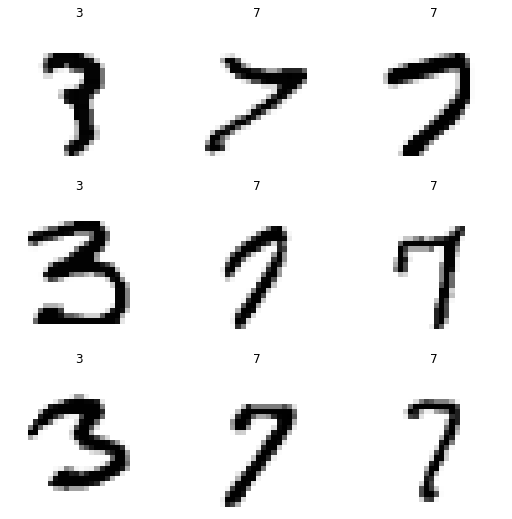

In [6]:
dls = datablock.dataloaders(path)
dls.device, dls.vocab, dls.show_batch()

## Lenet implementations

In [15]:
class MyLenet(nn.Module):
    """Lenet with convs and F.max_pool2d"""
    def __init__(self):
        super(MyLenet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3) # set 3 for first item if RGB
        self.conv2 = nn.Conv2d(6,16,3)
        self.hiden4 = nn.Linear(400, 2) # 2 outputs (3 and 7) instead of 10
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.hiden4(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

class Lenet2(nn.Module):
    """Lenet with layers"""
    def __init__(self):
        super(Lenet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3) # set 3 for first item if RGB
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2) # Only 2 outputs (3 and 7) instead of 10
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

## Lenet2 training

In [38]:
learner = Learner(dls, Lenet2(), metrics=accuracy, opt_func=Adam)
learner.summary()

Lenet2 (Input shape: ['64 x 1 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 6 x 26 x 26     60         True      
________________________________________________________________
Conv2d               64 x 16 x 11 x 11    880        True      
________________________________________________________________
Linear               64 x 120             48,120     True      
________________________________________________________________
Linear               64 x 84              10,164     True      
________________________________________________________________
Linear               64 x 2               170        True      
________________________________________________________________

Total params: 59,394
Total trainable params: 59,394
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fe698f02dd0>
Loss function: FlattenedLoss of CrossEntropyLoss()

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCall

CPU times: user 5 µs, sys: 4 µs, total: 9 µs
Wall time: 25 µs


SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0063095735386013985)

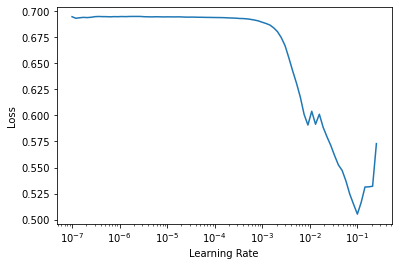

In [39]:
%time
learner.lr_find()

In [40]:
learner.fit(10, lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.800355,0.327434,0.959943,00:00
1,0.472445,0.052613,0.984263,00:00
2,0.319850,0.086929,0.977110,00:00
3,0.240990,0.059701,0.979971,00:00
4,0.190471,0.042913,0.987124,00:00
5,0.156513,0.051378,0.982833,00:00
6,0.133904,0.088141,0.977110,00:00
7,0.114094,0.104081,0.984263,00:00
8,0.102420,0.046226,0.987124,00:00
9,0.090814,0.088048,0.979971,00:00


# Setup all for TPU

In [ ]:
VERSION = "20200325"  #"20200515" @param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py

In [ ]:
#!TORCH_SHOW_CPP_STACKTRACES=1 python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev
!python pytorch-xla-env-setup.py

In [41]:
!pip install git+https://github.com/butchland/fastai_xla_extensions

  Cloning https://github.com/butchland/fastai_xla_extensions to /tmp/pip-req-build-dxb4i3sb
  Running command git clone -q https://github.com/butchland/fastai_xla_extensions /tmp/pip-req-build-dxb4i3sb


  Created wheel for fastai-xla-extensions: filename=fastai_xla_extensions-0.0.1-py3-none-any.whl size=10845 sha256=e1edcc5ef11c16ab8d442be623d5f7bfa452454411248d28efc6dee743ec51c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-85xecena/wheels/bc/e6/55/735127e1a9cb2e8131557223b31754c6184d6eee09cf3f7a8e
Successfully built fastai-xla-extensions


## Load via TPU

In [ ]:
tpu_device = xm.xla_device()
# Use same datablock, but load with TPU
dls_tpu = datablock.dataloaders(path, device=tpu_device)
dls.device, dls.vocab, dls.show_batch()

## learner train on TPU

In [ ]:
learner = Learner(dls, Lenet2(), metrics=accuracy, opt_func=Adam)
learner.summary()

In [ ]:
%time
learner.lr_find()

In [ ]:
learner.fit(10, lr=0.05) # 0.5 comes from GPU lr_find